
# Visualising Dirichlet Processes

Based on the great tutorial by Thomas at [this link](http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/).

A good reference on this material appears to be the workshop presented by Ye Whye Teh at MLSS 2007, 2013. Slides are available [here](http://www.columbia.edu/~jwp2128/Teaching/E6892/papers/mlss2007.pdf) and the recording (multiple parts) is available [here](https://www.youtube.com/watch?v=dNeW5zoNJ7g).


In [5]:

%matplotlib inline

import math
import random
import operator
import functools

import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.tri as tri
import matplotlib.pyplot as plt



## Urn Construction

Pólya's Urn Scheme is a constructive way to sample form a Dirichlet Process distribution.

Consider an urn filled with $\alpha$ black balls.

Until we have enough observations;

 1. Pick a ball from the urn
    
    a. If it is black, generate a new (non-black) color from some distribution, make a new ball that is of this color, then drop both balls into the urn. Return the color we selected as this observation.
    
    b. If the ball is not black, make a new ball that matches the color of the drawn ball, drop both balls back into the urn. Return the color we draw as this observation.

A simple python implementation follows;


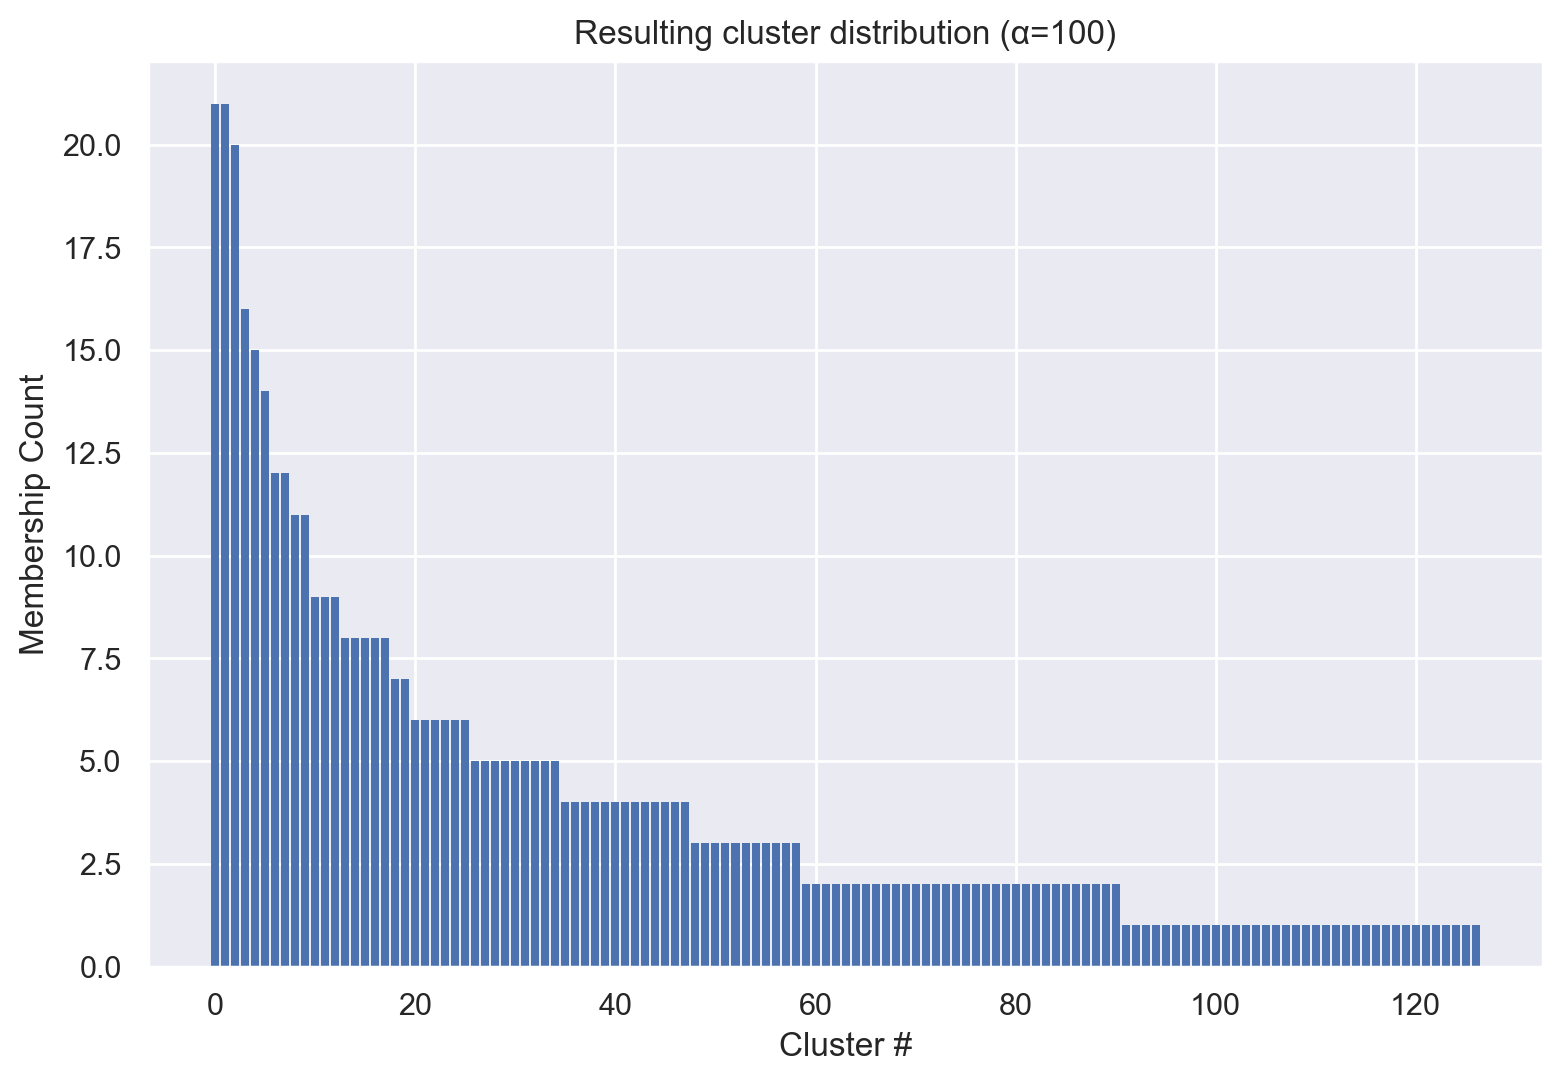

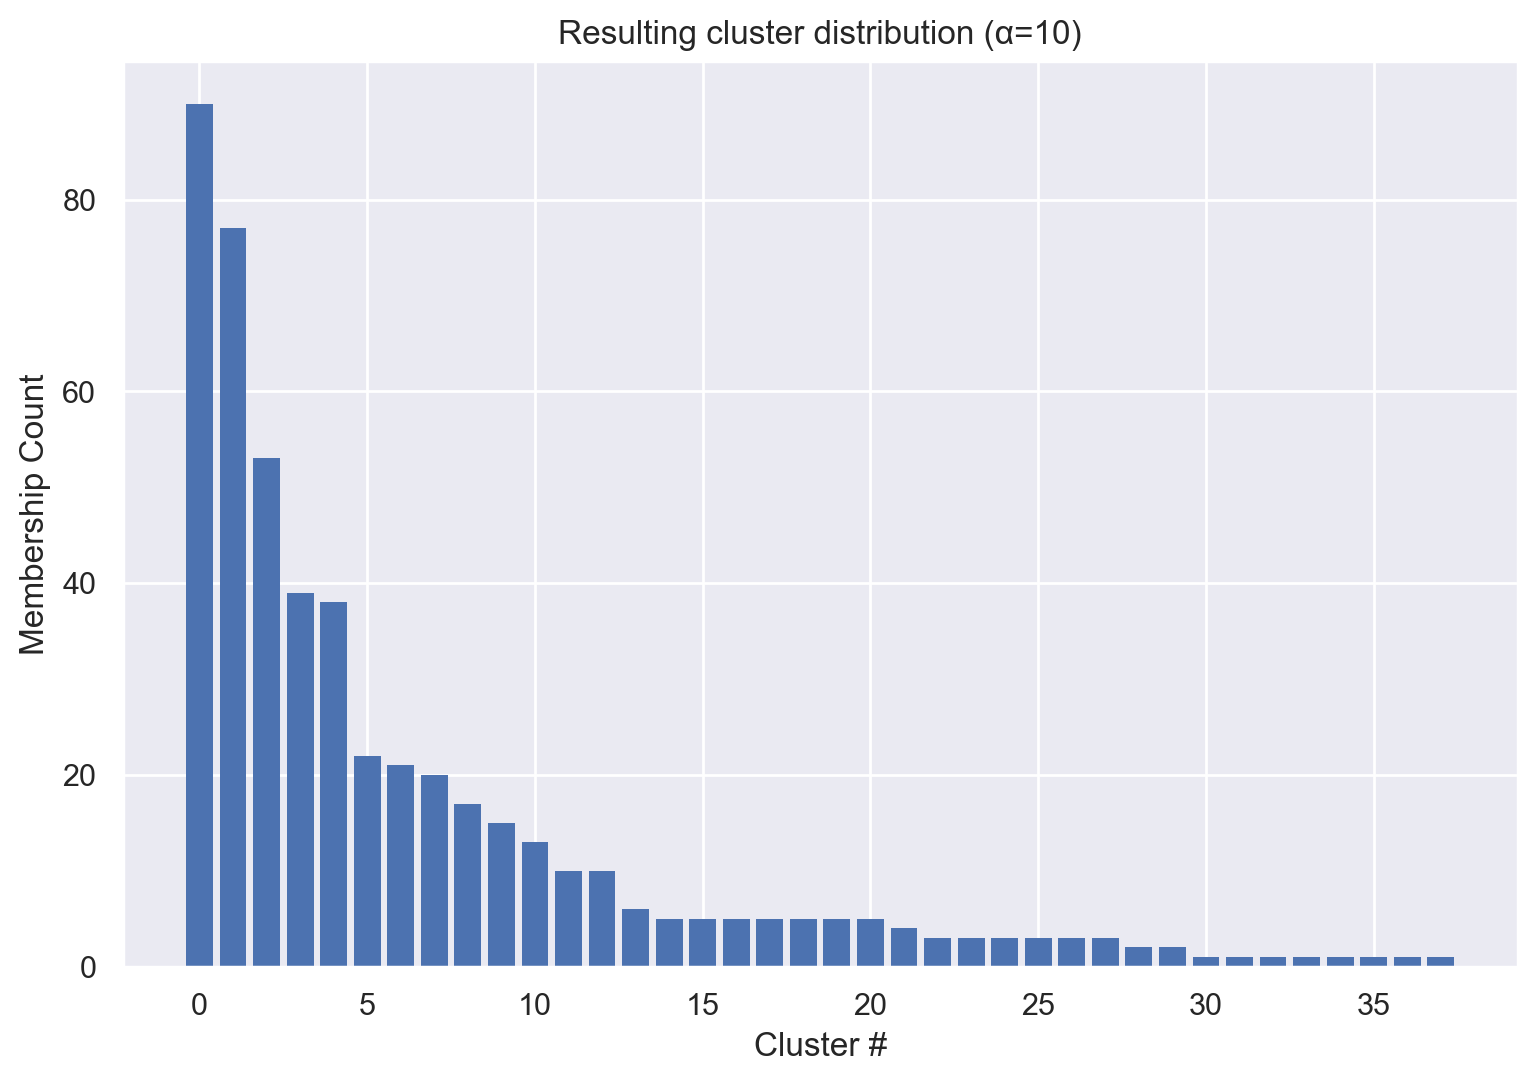

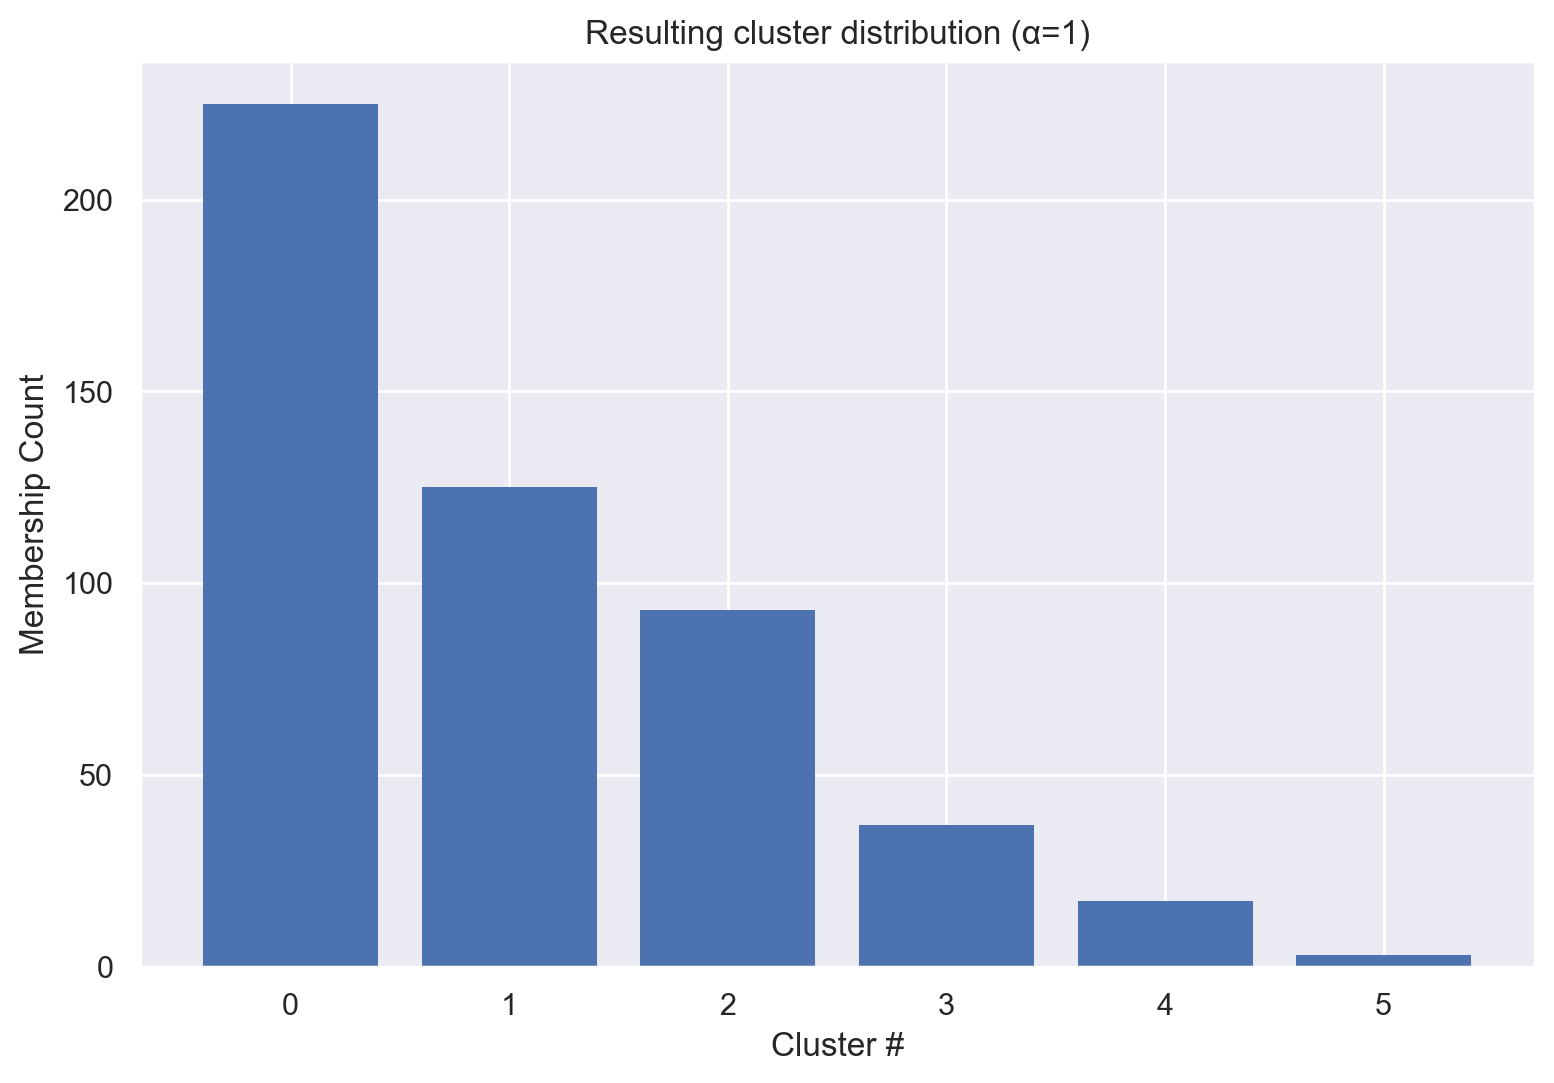

In [64]:

# Bound the space of possible colors
num_colors = 300
new_color = lambda: np.random.randint(0, num_colors)


class Ball():
    
    def __init__(self, color=None):
        # None corresponds to a black ball
        self.color = color
    
    def __repr__(self):
        return "Ball({})".format(
            self.color if self.color is not None else ''
        )


def urn_sampling(alpha=10, num_observations=500):
    """The Urn construction scheme follows
    """
    observations = {}
    urn = [Ball() for _ in range(alpha)]

    for obs in range(num_observations):

        # Step 1 - draw a random ball
        ball = random.choice(urn)

        if ball.color is None:
            # Step 1a - sapmle a new color
            color = new_color()
        else:
            # Step 1b - duplicate the color we drew
            color = ball.color

        # Add the new ball and the drawn ball back to the urn
        urn.append(Ball(color))

        # Update our observation dictionary
        observations[color] = observations.get(color, 0) + 1

    # Sort the cluster membership counts
    count = list(sorted(list(observations.values()))[::-1])
    x = list(range(len(count)))
    
    # Return vectors of cluster IDs and number of cluster members
    return (x, count)

# Plot cluster size histograms
sns.set()

plt.figure(figsize=(9, 6), dpi=200)
plt.bar(*urn_sampling(100), lw=0)
plt.xlabel("Cluster #")
plt.ylabel("Membership Count")
plt.title("Resulting cluster distribution (α=100)")
plt.show()

plt.figure(figsize=(9, 6), dpi=200)
plt.bar(*urn_sampling(10), lw=0)
plt.xlabel("Cluster #")
plt.ylabel("Membership Count")
plt.title("Resulting cluster distribution (α=10)")
plt.show()

plt.figure(figsize=(9, 6), dpi=200)
plt.bar(*urn_sampling(1), lw=0)
plt.xlabel("Cluster #")
plt.ylabel("Membership Count")
plt.title("Resulting cluster distribution (α=1)")
plt.show()



## Chinese Restaurant Construction

Another constructive method to sample from a Dirichlet process is the Chinese Restaurant Process.




In [2]:
corners = np.array([
    [0, 0],
    [1, 0],
    [0.5, np.sin(np.deg2rad(60))]
])
midpoints = np.array([
    (corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0
    for i in range(3)
])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

def xy2bc(xy, tol=1e-3):
    """Convert XY coordinates to barycentric"""
    s = [
        (corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75
        for i in range(3)
    ]
    return np.clip(s, tol, 1.0 - tol)


class Dirichlet():
    
    def __init__(self, alpha):
        self.alpha = np.array(alpha).astype(np.float32)
        # Pre-compute coefficient
        self.coef = (
            math.gamma(np.sum(self.alpha)) /
            np.prod([math.gamma(a) for a in self.alpha])
        )
    
    def pdf(self, theta):
        """The Dirichlet PDF p(θ|α)
        
        Args:
            theta (numpy array): Barycentric parameter vector
        
        Returns:
            (float): PDF of theta given current alpha values
        """
        assert len(theta) == len(self.alpha), "Theta vector must match alpha vector size"
        return self.coef * np.prod([
            ti ** (ai - 1)
            for ti, ai in zip(theta, self.alpha)
        ])


In [3]:

def plot_pdf(dist, nlevels=300, subdiv=7, cmap='afmhot_r', annotate=False, **kwargs):
    """Plot the PDF as a contour
    """
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pdf = [
        dist.pdf(xy2bc(xy))
        for xy in zip(trimesh.x, trimesh.y)
    ]
    
    plt.tricontourf(trimesh, pdf, nlevels, cmap=cmap, **kwargs)
    plt.axis("equal")
    plt.xlim(0, 1)
    plt.ylim(0, 0.75 ** 0.5)
    
    # Draw the simplex boundary
    plt.gca().add_patch(
        mpl.patches.Polygon(corners, closed=True, fill=False, lw=0.1, color='k')
    )
    plt.axis("off")
    plt.title(f"Dir(α = {dist.alpha})", weight='bold', pad=0.0)
    
    if annotate:
        plt.annotate(
            r'$\theta = (1, 0, 0)$',
            (0, 0),
            (-12, -8),
            textcoords='offset points',
            horizontalalignment='center',
            verticalalignment='center'
        )
        plt.annotate(
            r'$\theta = (0, 1, 0)$',
            (1, 0),
            (12, -8),
            textcoords='offset points',
            horizontalalignment='center',
            verticalalignment='center'
        )
        plt.annotate(
            r'$\theta = (0, 0, 1)$',
            (0.5, 0.75 ** 0.5),
            (0, 8),
            textcoords='offset points',
            horizontalalignment='center',
            verticalalignment='center'
        )



C:\Users\uqasnosw\AppData\Local\Continuum\miniconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


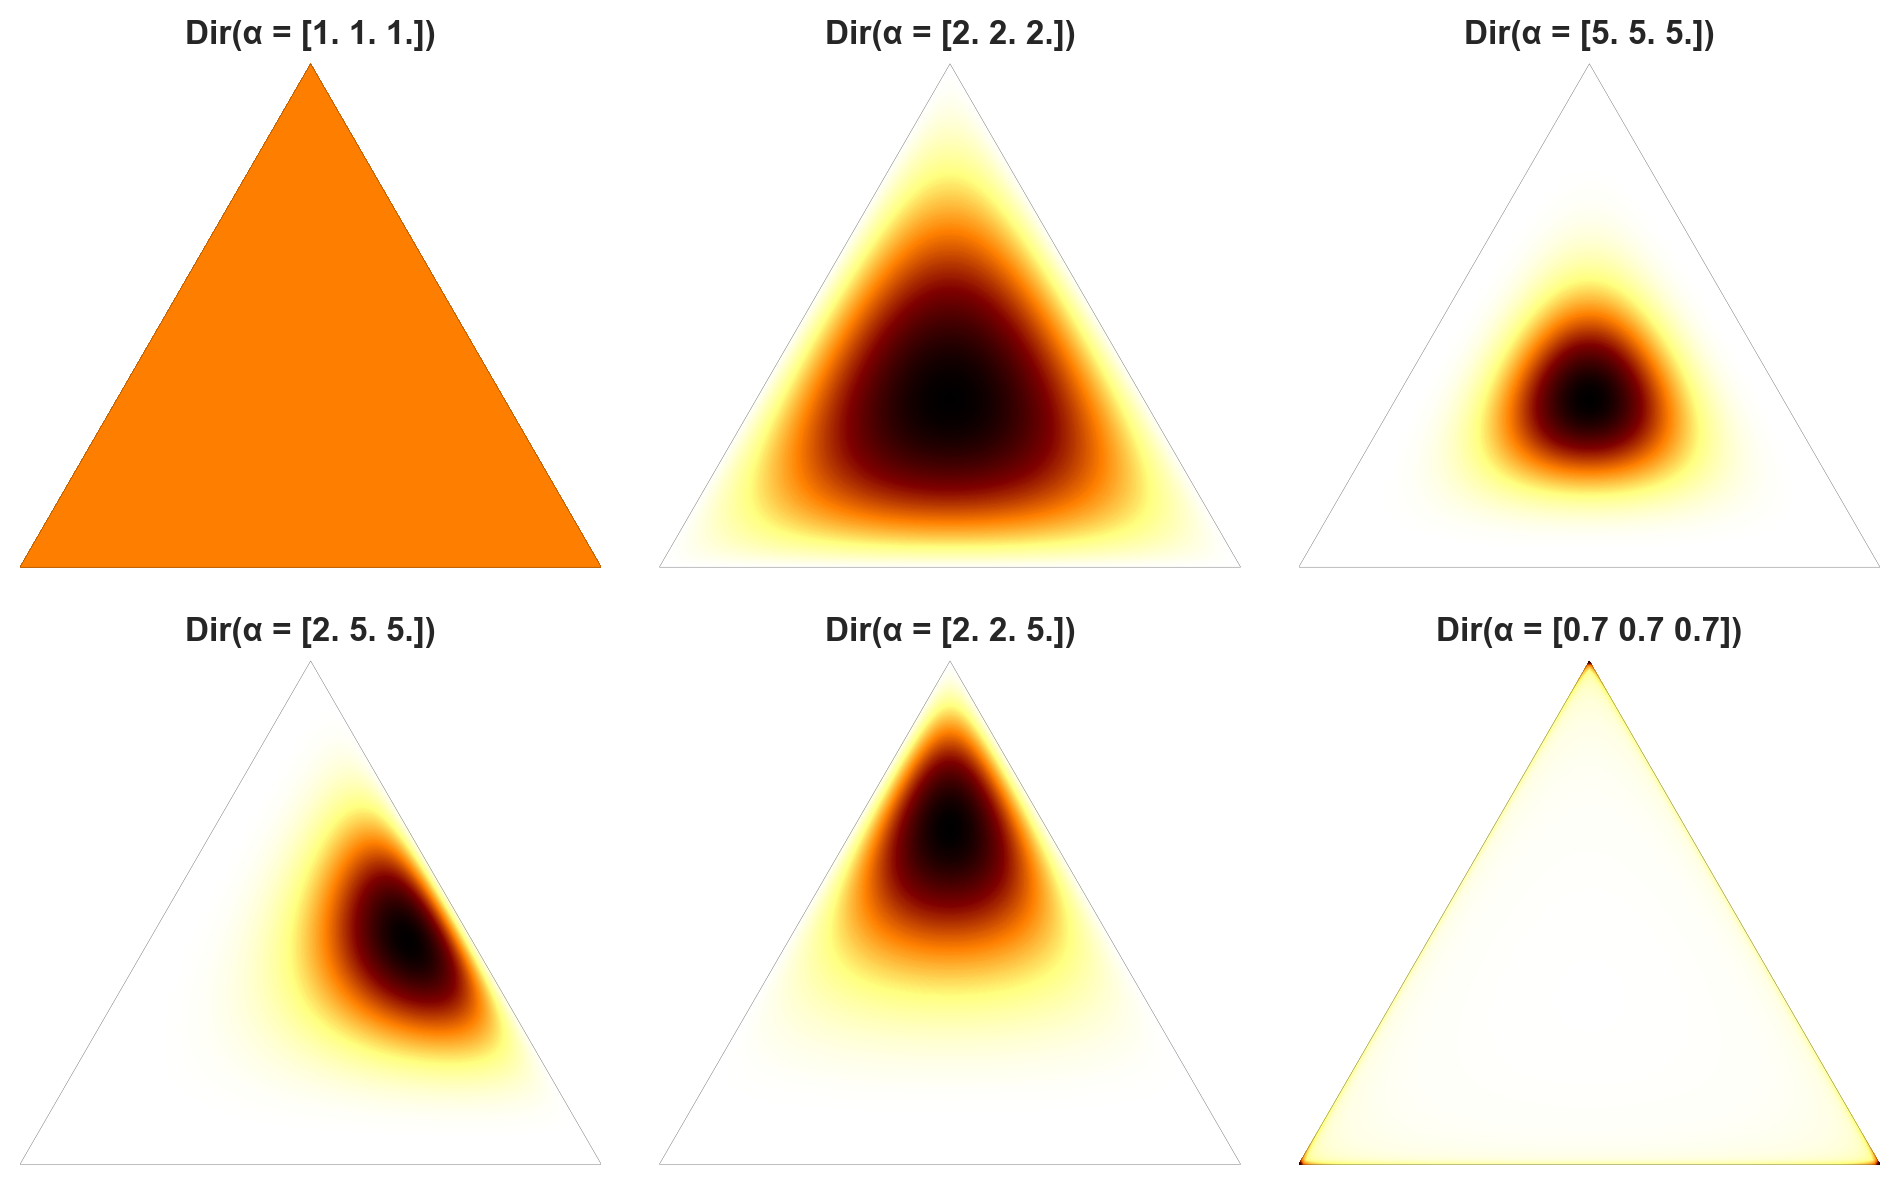

In [4]:

sns.set()
fig, axs = plt.subplots(
    2,
    3,
    figsize=(12, 12),
    dpi=200,
    gridspec_kw=dict(wspace=0.1, hspace=0.1)
)

plt.sca(axs[0, 0])
plot_pdf(Dirichlet([1, 1, 1]))

plt.sca(axs[0, 1])
plot_pdf(Dirichlet([2, 2, 2]))

plt.sca(axs[0, 2])
plot_pdf(Dirichlet([5, 5, 5]))

plt.sca(axs[1, 0])
plot_pdf(Dirichlet([2, 5, 5]))

plt.sca(axs[1, 1])
plot_pdf(Dirichlet([2, 2, 5]))

plt.sca(axs[1, 2])
plot_pdf(Dirichlet([0.7, 0.7, 0.7]))

plt.tight_layout()
plt.subplots_adjust(top=0.6)
plt.show()



## Scikit-learn implementation

Scikit-learn includes an implementation of Dirichlet Prior Gaussian Mixture Model clustering via the [`BayesianGausianMixture`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html) class.

The scikit-learn implementation uses variational inference, which is a slightly more sophisticated approach than Gibbs sampling.

Demo code is from [this tutorial page](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html).


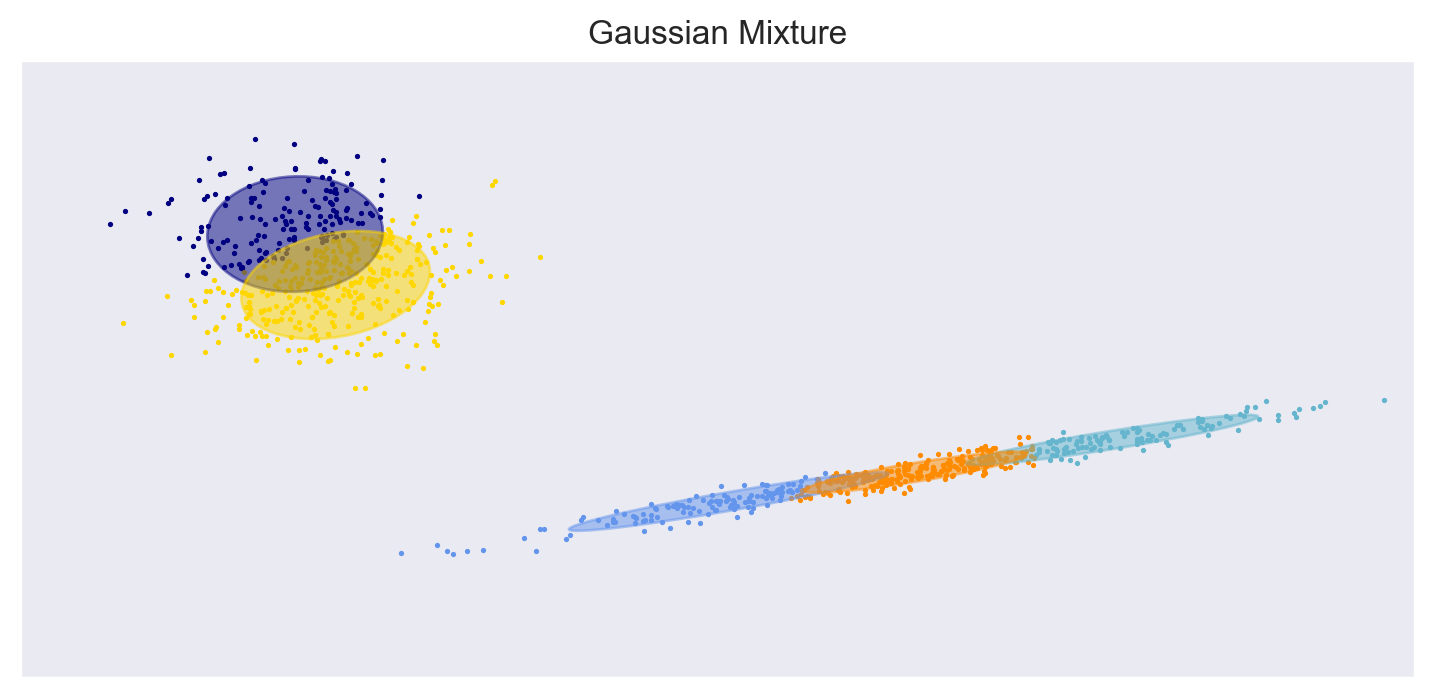

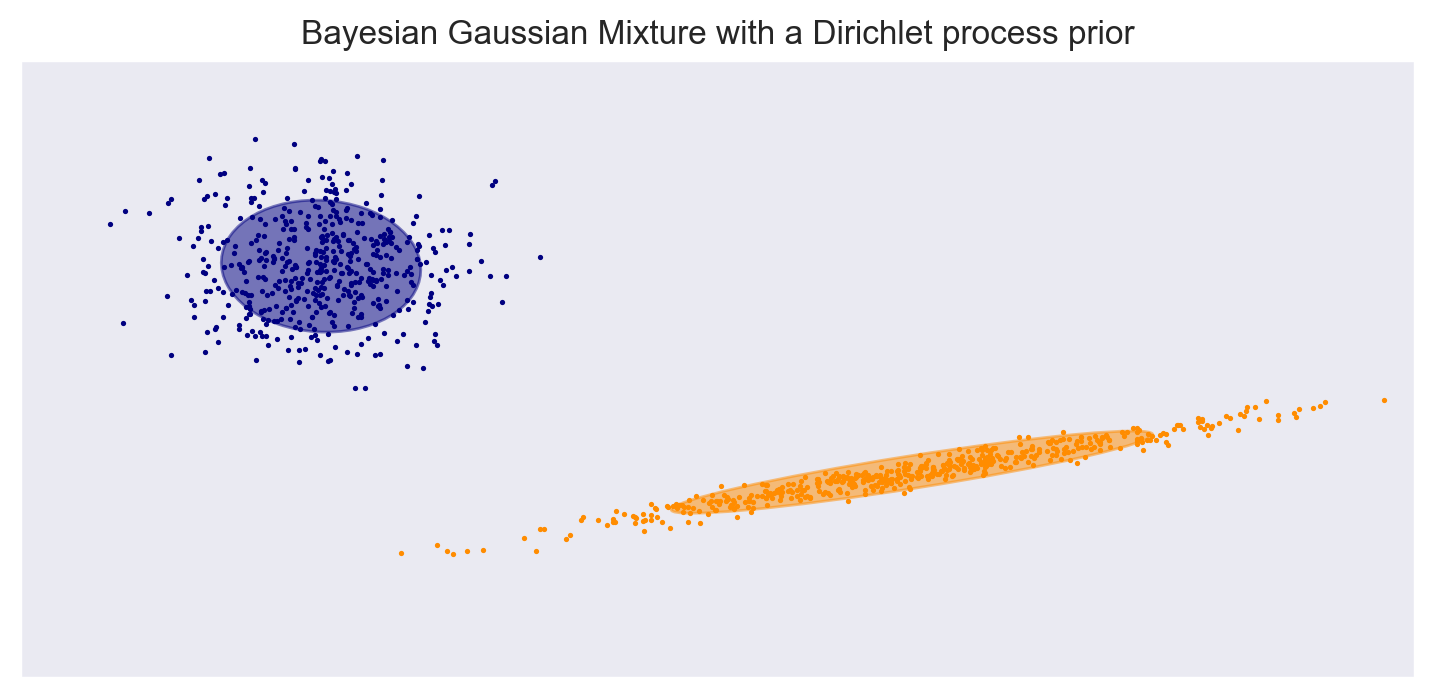

In [12]:
import itertools

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import linalg
from sklearn import mixture

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def plot_results(X, Y_, means, covariances, index, title):
    sns.set()
    plt.figure(figsize=(9, 9), dpi=200)
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)


# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]

# Fit a Gaussian mixture with EM using five components
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full').fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')

# Fit a Dirichlet process Gaussian mixture using five components
dpgmm = mixture.BayesianGaussianMixture(
    n_components=5,
    covariance_type='full'
).fit(X)

plot_results(
    X,
    dpgmm.predict(X),
    dpgmm.means_,
    dpgmm.covariances_,
    1,
    'Bayesian Gaussian Mixture with a Dirichlet process prior'
)

plt.show()



## Combining DP priors with deep learning

When it comes to combining non-parametric Bayes DP priors with deep learning, the canonical approach appears to be the 2017 ICLR paper [Stick-breaking variational autoencoders](https://arxiv.org/pdf/1605.06197.pdf) by Nalisnick and Smyth.

He has also given some associated tutorial presentations on the same topic:

 * [Deep generative models with stick-breaking priors](https://www.ics.uci.edu/~enalisni/nalisnick_uciAIML_talk.pdf)
 * [Alternative priors for deep generative models](https://www.ics.uci.edu/~enalisni/nalisnick_uciAIML_talk.pdf)
